In [43]:
from utils.util import mkdir,seed_all
from omegaconf import OmegaConf
from cprint import *
from datasets.shape_net import ShapeNet
import torch
from models.Transform2D import Transform2D
from tqdm.notebook import tqdm
from torch.utils.tensorboard import SummaryWriter
from utils.visualizations import save_voxels
from PIL import Image
import os
import numpy as np
import datetime
%load_ext autoreload
%load_ext tensorboard
%autoreload 2

from evaluation.Evaluation import Evaluation

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [44]:
import time
seed_all(111)
today = time.strftime("%Y-%m-%d")
config = OmegaConf.load("./configs/global_configs.yaml")
cprint.ok(config)
description = "Checking Everything" # Describe Experiment params here
logs_dir = config["logs_dir"]
mkdir(logs_dir)
experiment_dir = f"{logs_dir}/{config['name']}"
mkdir(experiment_dir)
loss_log_title = "Loss Log " + today 

with open(f"{experiment_dir}/description.txt", "w") as file1:
    file1.write(description)
    
with open(f"{experiment_dir}/configs.txt", "w") as file1:
    file1.write(str(config))

with open(f"{experiment_dir}/loss_log.txt", "w") as file1:
    file1.write(loss_log_title)
    file1.write("\n")


mkdir(f"{experiment_dir}/checkpoints")
mkdir(f"{experiment_dir}/tb")
mkdir(f"{experiment_dir}/visuals")
mkdir(f"{experiment_dir}/evaluation")

{'logs_dir': 'logs/final_models/evaluations/transformer_fusion', 'is_train': True, 'name': '1_views_plz', 'device': 'cuda:0', 'batch_size': 8, 'n_epochs': 100, 'append_loss_every': 50, 'print_every': 150, 'validate_every': 4349, 'save_every': 500, 'save_every_nepochs': 10, 'start_epoch': 0, 'start_iteration': 0, 'visualize_every': 1000, 'model': {'lr': 0.0001, 'criterion': 'DICE_BCE', 'pos_weight': 'None', 'fusion': 'Transformer', 'encoder': {'patch_size': 16, 'sequence_length': 196, 'embedding_dim': 768, 'patch_padding': 3}, 'transformer_encoder': {'d_model': 768, 'nhead': 12, 'num_layers': 12}, 'transformer_decoder': {'d_model': 768, 'nhead': 12, 'num_layers': 8, 'num_pos_embeddings': 64}, 'fusion_decoder': {'d_model': 768, 'nhead': 6, 'num_layers': 2}}, 'evaluation': {'ckpt_path': 'logs/final_models/transformer_fusion/fusion_transformer_all_ds/checkpoints/epoch-latest.ckpt'}}
- logs/final_models/evaluations/transformer_fusion directory found


- Creating new directory logs/final_models/evaluations/transformer_fusion/1_views_plz
- Creating new directory logs/final_models/evaluations/transformer_fusion/1_views_plz/checkpoints
- Creating new directory logs/final_models/evaluations/transformer_fusion/1_views_plz/tb
- Creating new directory logs/final_models/evaluations/transformer_fusion/1_views_plz/visuals
- Creating new directory logs/final_models/evaluations/transformer_fusion/1_views_plz/evaluation


In [45]:
model = Transform2D()
# Declare device
device = torch.device('cpu')
if torch.cuda.is_available() and config['device'].startswith('cuda'):
    device = torch.device(config['device'])
    cprint.ok('Using device:', config['device'])
else:
    cprint.warn('Using CPU')

model.to(device)
model.load_ckpt(config['evaluation']['ckpt_path'])


Some weights of the model checkpoint at facebook/deit-base-distilled-patch16-224 were not used when initializing DeiTModel: ['cls_classifier.weight', 'distillation_classifier.bias', 'cls_classifier.bias', 'distillation_classifier.weight']
- This IS expected if you are initializing DeiTModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DeiTModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DeiTModel were not initialized from the model checkpoint at facebook/deit-base-distilled-patch16-224 and are newly initialized: ['deit.pooler.dense.bias', 'deit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference

Using device: cuda:0
Model loaded from logs/final_models/transformer_fusion/fusion_transformer_all_ds/checkpoints/epoch-latest.ckpt


In [46]:
dataset = ShapeNet(cat="all",is_overfit=False, nimgs=2) #Change overfit param here & cat here
print('length: ', len(dataset))
dataset[0]
train_ds, valid_ds, test_ds = torch.utils.data.random_split(
    dataset, [35026, 4379, 4378])



train_dataloader = torch.utils.data.DataLoader(
        train_ds,   # Datasets return data one sample at a time; Dataloaders use them and aggregate samples into batches
        batch_size=config['batch_size'],   # The size of batches is defined here
        shuffle=True,    # Shuffling the order of samples is useful during training to prevent that the network learns to depend on the order of the input data
        num_workers=6,   # Data is usually loaded in parallel by num_workers
        pin_memory=True,  # This is an implementation detail to speed up data uploading to the GPU
        # worker_init_fn=train_dataset.worker_init_fn  TODO: Uncomment this line if you are using shapenet_zip on Google Colab
    )

validation_dataloader = torch.utils.data.DataLoader(
        valid_ds,   # Datasets return data one sample at a time; Dataloaders use them and aggregate samples into batches
        batch_size=config['batch_size'],   # The size of batches is defined here
        shuffle=True,    # Shuffling the order of samples is useful during training to prevent that the network learns to depend on the order of the input data
        num_workers=6,   # Data is usually loaded in parallel by num_workers
        pin_memory=True,  # This is an implementation detail to speed up data uploading to the GPU
        # worker_init_fn=train_dataset.worker_init_fn  TODO: Uncomment this line if you are using shapenet_zip on Google Colab
    )

test_dataloader = torch.utils.data.DataLoader(
        test_ds,   # Datasets return data one sample at a time; Dataloaders use them and aggregate samples into batches
        batch_size=config['batch_size'],   # The size of batches is defined here
        shuffle=True,    # Shuffling the order of samples is useful during training to prevent that the network learns to depend on the order of the input data
        num_workers=6,   # Data is usually loaded in parallel by num_workers
        pin_memory=True,  # This is an implementation detail to speed up data uploading to the GPU
        # worker_init_fn=train_dataset.worker_init_fn  TODO: Uncomment this line if you are using shapenet_zip on Google Colab
    )




length:  43783


0it [00:00, ?it/s]

Avg IOU:  0.5494635436497565


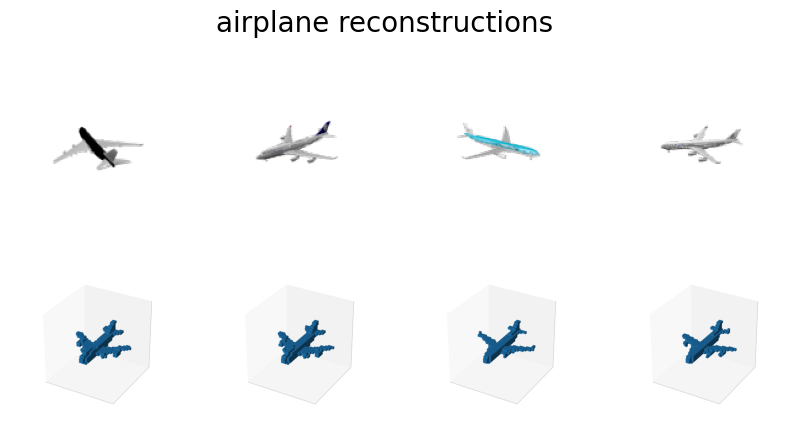

logs/final_models/evaluations/transformer_fusion/1_views_plz/evaluation/airplane_evaluation saved


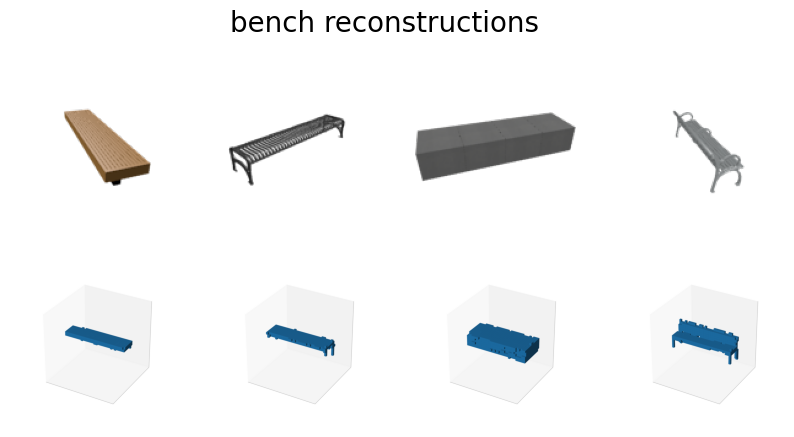

logs/final_models/evaluations/transformer_fusion/1_views_plz/evaluation/bench_evaluation saved


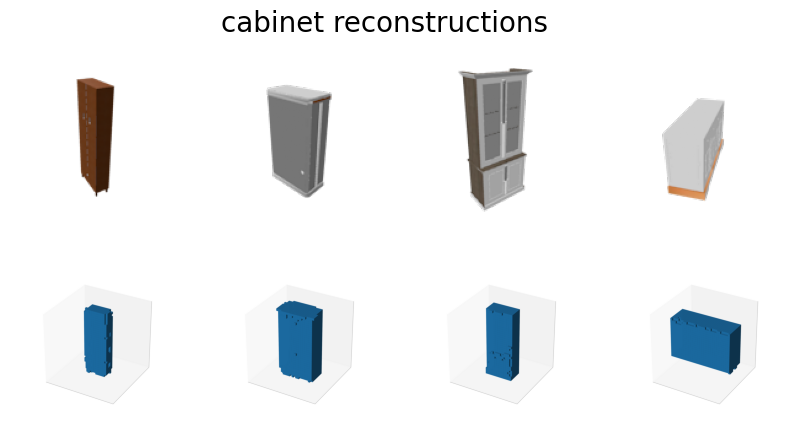

logs/final_models/evaluations/transformer_fusion/1_views_plz/evaluation/cabinet_evaluation saved


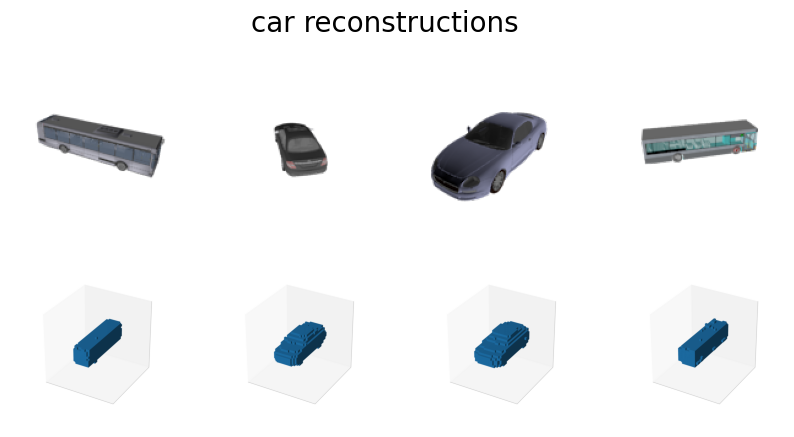

logs/final_models/evaluations/transformer_fusion/1_views_plz/evaluation/car_evaluation saved


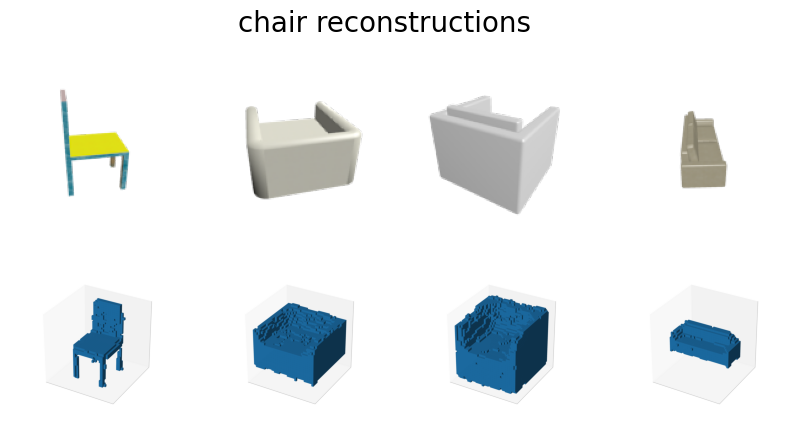

logs/final_models/evaluations/transformer_fusion/1_views_plz/evaluation/chair_evaluation saved


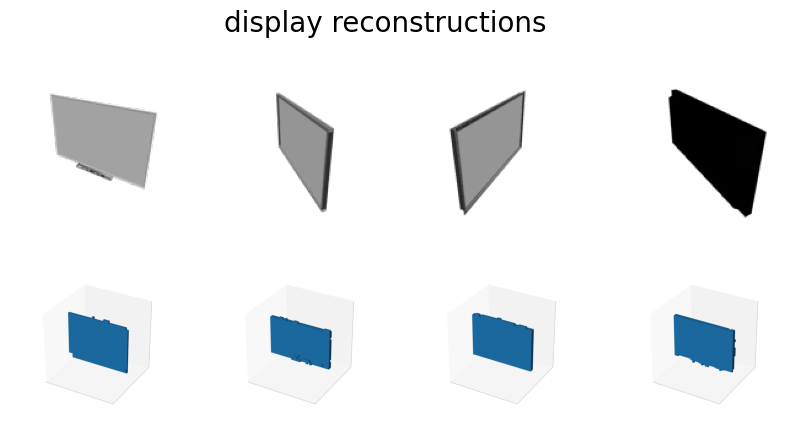

logs/final_models/evaluations/transformer_fusion/1_views_plz/evaluation/display_evaluation saved


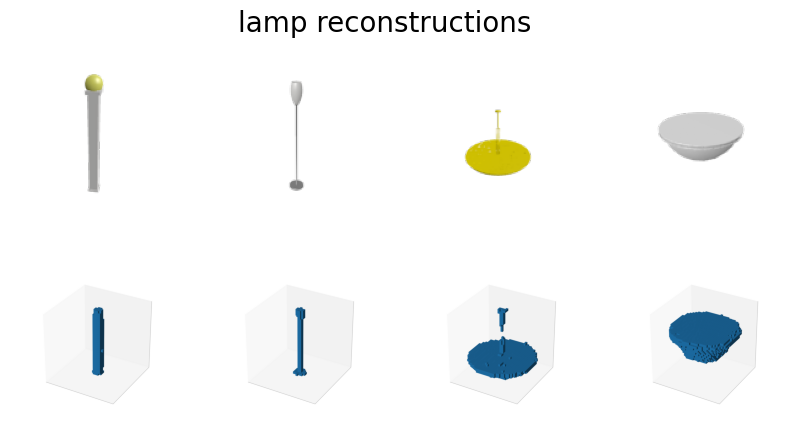

logs/final_models/evaluations/transformer_fusion/1_views_plz/evaluation/lamp_evaluation saved


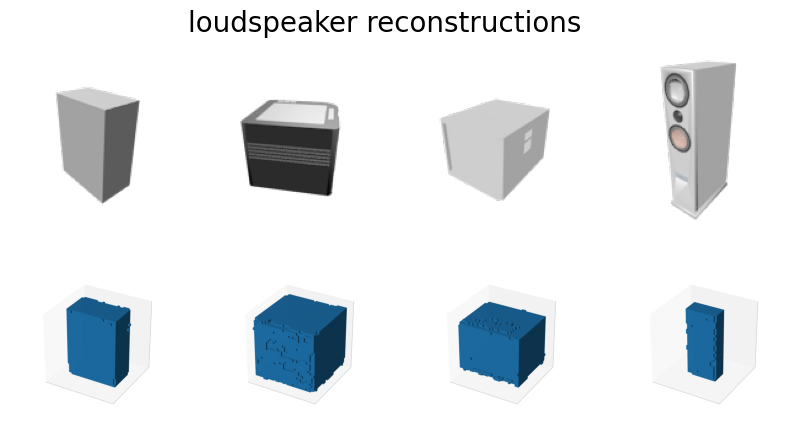

logs/final_models/evaluations/transformer_fusion/1_views_plz/evaluation/loudspeaker_evaluation saved


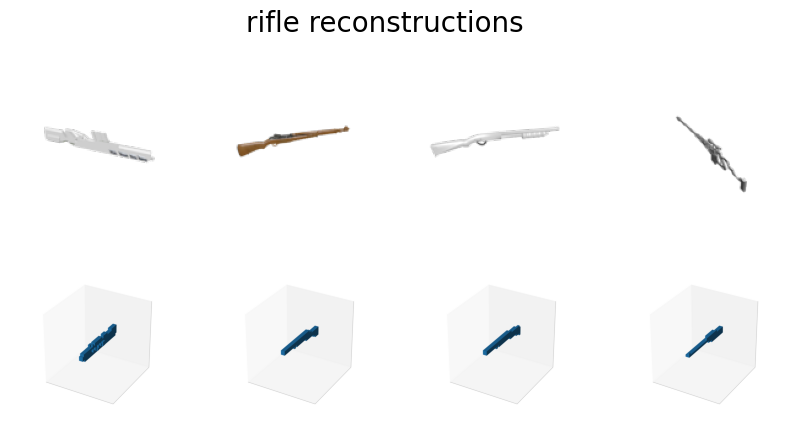

logs/final_models/evaluations/transformer_fusion/1_views_plz/evaluation/rifle_evaluation saved


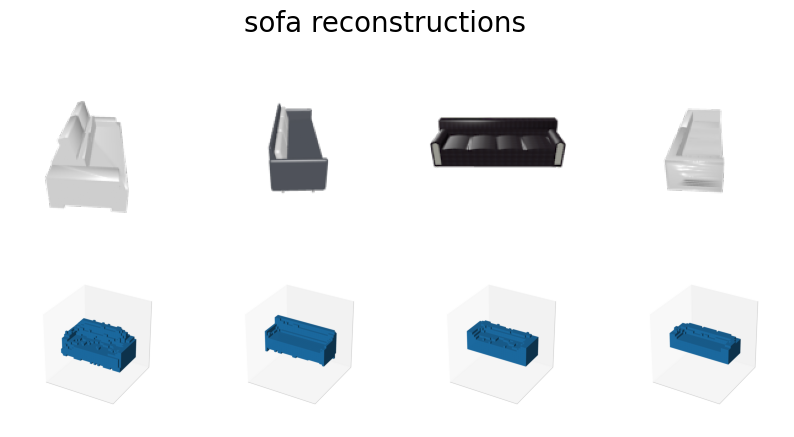

logs/final_models/evaluations/transformer_fusion/1_views_plz/evaluation/sofa_evaluation saved


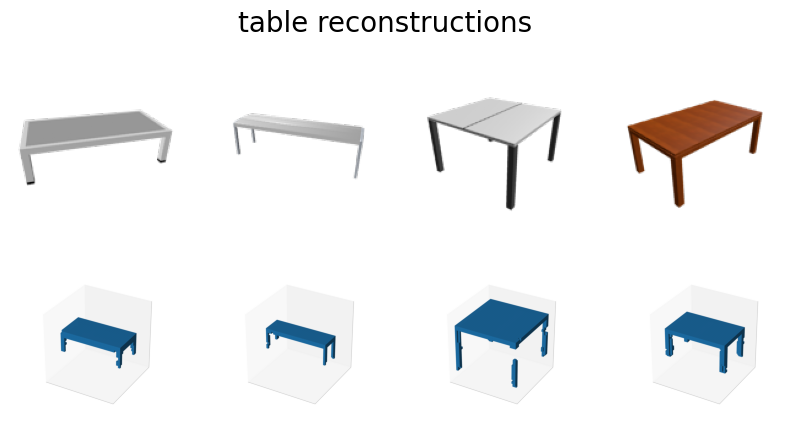

logs/final_models/evaluations/transformer_fusion/1_views_plz/evaluation/table_evaluation saved


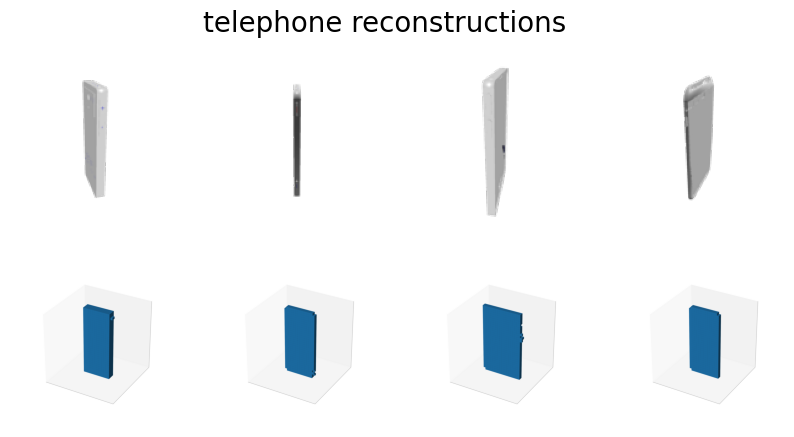

logs/final_models/evaluations/transformer_fusion/1_views_plz/evaluation/telephone_evaluation saved


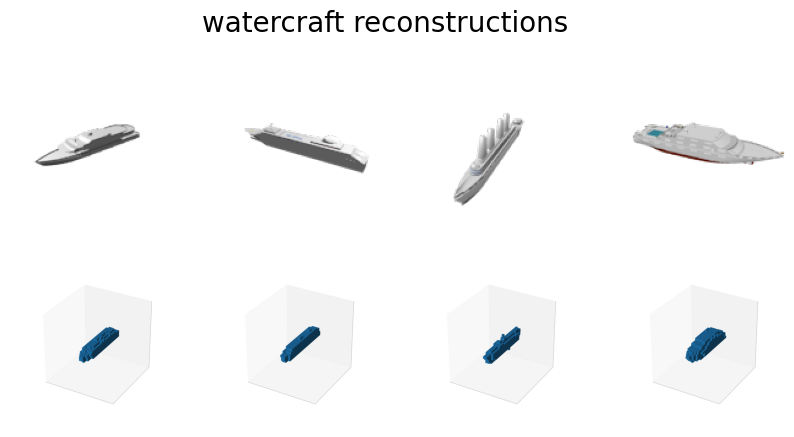

logs/final_models/evaluations/transformer_fusion/1_views_plz/evaluation/watercraft_evaluation saved


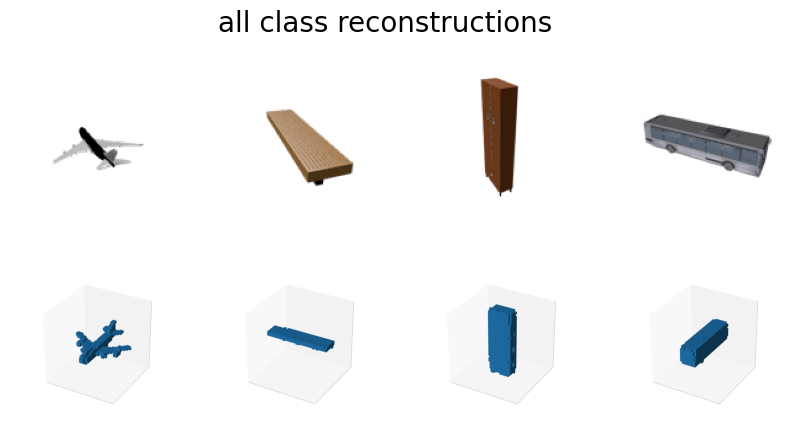

logs/final_models/evaluations/transformer_fusion/1_views_plz/evaluation/all_1 saved


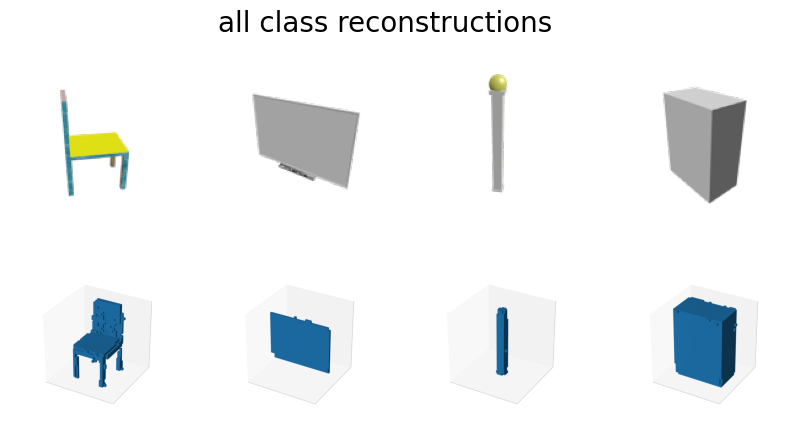

logs/final_models/evaluations/transformer_fusion/1_views_plz/evaluation/all_2 saved


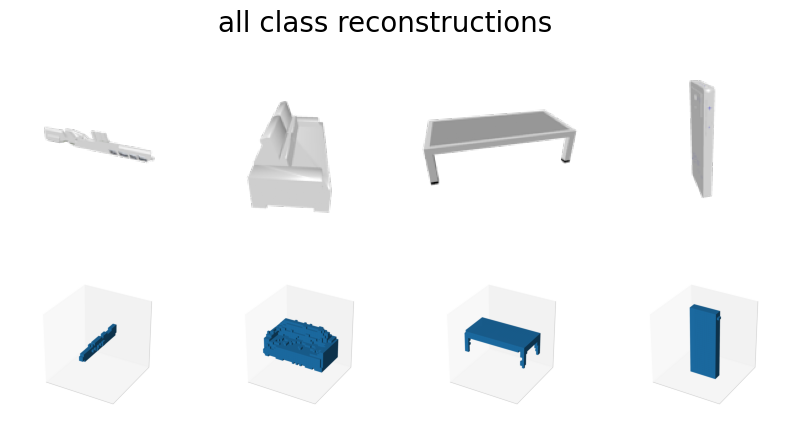

logs/final_models/evaluations/transformer_fusion/1_views_plz/evaluation/all_3 saved
Saved:logs/final_models/evaluations/transformer_fusion/1_views_plz/evaluation/evaluation.json


In [47]:
evaluator = Evaluation(test_dataloader, model, device, f"{experiment_dir}/evaluation")
evaluator.evaluate()
evaluator.class_visualizations()
evaluator.all_visualizations()
evaluator.save_dict()